<a href="https://colab.research.google.com/github/ShohanNur/Machine_Leanring/blob/main/notebooks/train-yolov12-object-detection-model_50epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [2]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [3]:
!nvidia-smi

Sat Aug 30 12:20:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [5]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 91.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 89.9 MB/s eta 0:00:00


### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [6]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-08-30 12:21:13--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-08-30 12:21:13 (94.9 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


100%|██████████| 51.4M/51.4M [00:00<00:00, 206MB/s]


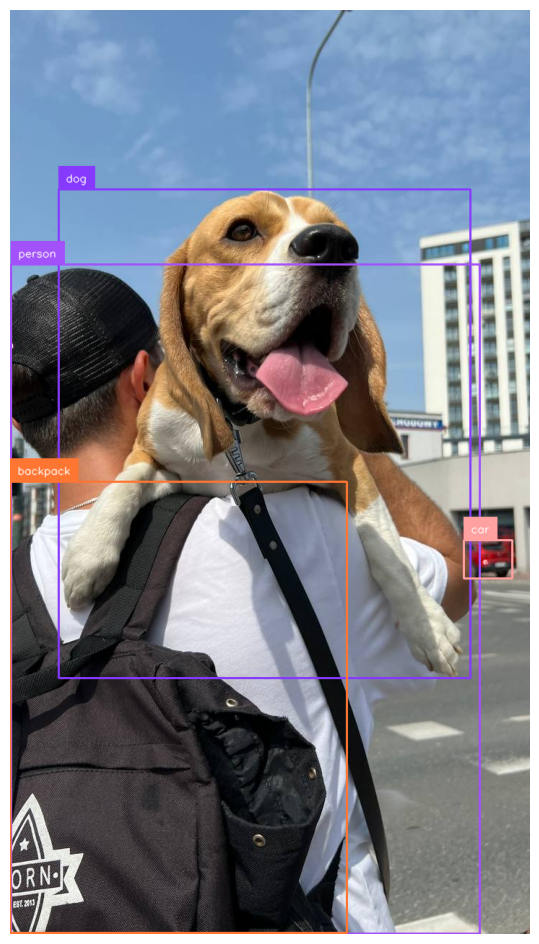

In [7]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [8]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="pZ87n68pYMoWbLoYXmt3")
project = rf.workspace("hello-prhln").project("weeds_detection_test")
version = project.version(1)
dataset = version.download("yolov12")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Weeds_Detection_Test-1 in yolov12:: 100%|██████████| 14714/14714 [00:05<00:00, 2876.20it/s]


In [9]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [10]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [11]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 12
names: ['Alternanthera philoxeroide', 'Centella asiatica', 'Colocasia esculenta', 'Commelina benghalensis', 'Cyperus ochraceus', 'Fimbristylis littoralis', 'Ipomoea aquatica', 'Marsilea minuta', 'Panicum repens', 'Paspalum scrobiculatum', 'Pteris vittata', 'Synedrella nodiflora']

roboflow:
  workspace: hello-prhln
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [12]:
from ultralytics import YOLO

model = YOLO('yolov12s.pt')

results = model.train(
    data=f'{dataset.location}/data.yaml',
    epochs=50,          # reduced from 200 → faster
    imgsz=640,          # smaller image size = much faster
    batch=32,           # increase batch if GPU VRAM allows
    device=0,
    patience=20,        # early stop if no improvement
    save_period=10,
    close_mosaic=15
)


100%|██████████| 17.8M/17.8M [00:00<00:00, 117MB/s] 


New https://pypi.org/project/ultralytics/8.3.189 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.pt, data=/content/Weeds_Detection_Test-1/data.yaml, epochs=50, time=None, patience=20, batch=32, imgsz=640, save=True, save_period=10, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=15, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False,

100%|██████████| 755k/755k [00:00<00:00, 27.2MB/s]


Overriding model.yaml nc=80 with nc=12

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2, 1, 2]          
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2, 1, 4]        
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    677120  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytic

100%|██████████| 5.26M/5.26M [00:00<00:00, 95.3MB/s]


AMP: checks passed ✅


train: Scanning /content/Weeds_Detection_Test-1/train/labels... 6432 images, 12 backgrounds, 0 corrupt: 100%|██████████| 6432/6432 [00:02<00:00, 2527.96it/s]


train: New cache created: /content/Weeds_Detection_Test-1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/Weeds_Detection_Test-1/valid/labels... 613 images, 1 backgrounds, 0 corrupt: 100%|██████████| 613/613 [00:00<00:00, 1243.59it/s]

val: New cache created: /content/Weeds_Detection_Test-1/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000625, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50        13G     0.9374      1.978      1.557         92        640: 100%|██████████| 201/201 [03:30<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]

                   all        613        707      0.691      0.627      0.693      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50        13G     0.9615      1.357      1.542        107        640: 100%|██████████| 201/201 [03:19<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]

                   all        613        707      0.733      0.697       0.77      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      13.3G     0.9371       1.29      1.519         98        640: 100%|██████████| 201/201 [03:17<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]

                   all        613        707      0.691      0.667      0.723       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50        13G     0.9342      1.262      1.518         86        640: 100%|██████████| 201/201 [03:17<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]

                   all        613        707      0.668      0.779      0.759      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      13.3G     0.9079      1.177      1.497         87        640: 100%|██████████| 201/201 [03:16<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]

                   all        613        707       0.83       0.76      0.835      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50        13G      0.866       1.09      1.467        102        640: 100%|██████████| 201/201 [03:16<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]

                   all        613        707      0.829      0.868      0.896      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50        13G     0.8443      1.029      1.444        102        640: 100%|██████████| 201/201 [03:16<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]

                   all        613        707      0.873      0.851      0.904       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50        13G     0.8403     0.9673      1.438        106        640: 100%|██████████| 201/201 [03:17<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]

                   all        613        707      0.866      0.893      0.914       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      13.3G     0.8147     0.9196      1.417        100        640: 100%|██████████| 201/201 [03:16<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]

                   all        613        707      0.878      0.842      0.906      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50        13G     0.8007      0.875      1.403        101        640: 100%|██████████| 201/201 [03:16<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]

                   all        613        707      0.877      0.898      0.918      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50        13G     0.7938     0.8645      1.399        112        640: 100%|██████████| 201/201 [03:16<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.43it/s]

                   all        613        707      0.902      0.858       0.92      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50        13G     0.7783     0.8362      1.386         96        640: 100%|██████████| 201/201 [03:16<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

                   all        613        707      0.866      0.888      0.921      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      13.3G     0.7625     0.7994      1.373         91        640: 100%|██████████| 201/201 [03:16<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]

                   all        613        707      0.925      0.896      0.938       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50        13G     0.7603     0.7951      1.372         95        640: 100%|██████████| 201/201 [03:16<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]

                   all        613        707      0.919      0.894      0.941      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50        13G     0.7591     0.7695      1.369         88        640: 100%|██████████| 201/201 [03:16<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        613        707       0.92      0.918      0.941      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50        13G     0.7437     0.7592      1.361         94        640: 100%|██████████| 201/201 [03:16<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]

                   all        613        707      0.944        0.9      0.945      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      13.3G     0.7305     0.7469      1.348         99        640: 100%|██████████| 201/201 [03:16<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]

                   all        613        707      0.926      0.901      0.946      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50        13G      0.732     0.7328      1.347         83        640: 100%|██████████| 201/201 [03:16<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]

                   all        613        707      0.914      0.902      0.941      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50        13G     0.7342     0.7163      1.347         98        640: 100%|██████████| 201/201 [03:16<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]

                   all        613        707      0.919      0.915      0.943      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50        13G     0.7256     0.6969      1.334         97        640: 100%|██████████| 201/201 [03:16<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]

                   all        613        707      0.926      0.909      0.948      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      13.3G     0.7149     0.6906      1.335         91        640: 100%|██████████| 201/201 [03:16<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]

                   all        613        707      0.938       0.92      0.952      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50        13G     0.7065     0.6752      1.326        104        640: 100%|██████████| 201/201 [03:16<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]

                   all        613        707      0.959      0.921      0.956      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50        13G     0.7009     0.6589       1.32         89        640: 100%|██████████| 201/201 [03:16<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]

                   all        613        707      0.913       0.93      0.947      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50        13G     0.6844      0.638      1.308         91        640: 100%|██████████| 201/201 [03:17<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]

                   all        613        707       0.93      0.935      0.955      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      13.3G     0.6905     0.6421      1.313         80        640: 100%|██████████| 201/201 [03:16<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]

                   all        613        707      0.929      0.947      0.958       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50        13G     0.6787     0.6314        1.3         98        640: 100%|██████████| 201/201 [03:16<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]

                   all        613        707      0.931      0.945      0.963      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50        13G     0.6728     0.6144      1.299         94        640: 100%|██████████| 201/201 [03:16<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]

                   all        613        707      0.936      0.932      0.955        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50        13G     0.6728     0.6036      1.297         94        640: 100%|██████████| 201/201 [03:17<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]

                   all        613        707      0.929      0.938      0.953      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      13.3G     0.6649     0.6032       1.29         92        640: 100%|██████████| 201/201 [03:18<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

                   all        613        707       0.94      0.944      0.956      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50        13G     0.6686     0.6052      1.293        106        640: 100%|██████████| 201/201 [03:18<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

                   all        613        707      0.952      0.938      0.962      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50        13G     0.6497     0.5759      1.277         88        640: 100%|██████████| 201/201 [03:18<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]

                   all        613        707      0.947      0.938      0.956      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50        13G      0.641      0.567      1.274         92        640: 100%|██████████| 201/201 [03:18<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]

                   all        613        707      0.956      0.942      0.961      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      13.4G     0.6357     0.5618      1.264         83        640: 100%|██████████| 201/201 [03:17<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]

                   all        613        707      0.933      0.945       0.96      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50        13G     0.6391     0.5546      1.266        100        640: 100%|██████████| 201/201 [03:17<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]

                   all        613        707      0.945      0.941      0.954      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      13.3G     0.6227     0.5363      1.252         99        640: 100%|██████████| 201/201 [03:18<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

                   all        613        707      0.952      0.939      0.961      0.728


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50        13G     0.6237     0.3751      1.361         39        640: 100%|██████████| 201/201 [03:18<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]

                   all        613        707       0.95      0.939      0.959      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      13.3G     0.5988     0.3578      1.341         41        640: 100%|██████████| 201/201 [03:17<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]

                   all        613        707      0.935      0.943      0.957      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50        13G     0.5846     0.3388      1.329         36        640: 100%|██████████| 201/201 [03:17<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]

                   all        613        707      0.941       0.94      0.955       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      13.3G     0.5736       0.33      1.315         41        640: 100%|██████████| 201/201 [03:17<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]

                   all        613        707      0.942      0.917      0.948      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50        13G     0.5551     0.3191      1.294         34        640: 100%|██████████| 201/201 [03:17<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

                   all        613        707      0.946      0.926      0.949      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      13.3G     0.5509     0.3105      1.294         34        640: 100%|██████████| 201/201 [03:17<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

                   all        613        707      0.956      0.926      0.958      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50        13G     0.5346     0.2998      1.275         32        640: 100%|██████████| 201/201 [03:17<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]

                   all        613        707      0.952      0.938      0.954      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      13.3G     0.5207     0.2912      1.259         41        640: 100%|██████████| 201/201 [03:17<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]

                   all        613        707      0.954       0.94      0.954      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50        13G     0.5135     0.2803      1.249         38        640: 100%|██████████| 201/201 [03:17<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]

                   all        613        707      0.951      0.943      0.956      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      13.3G     0.4971      0.272      1.234         39        640: 100%|██████████| 201/201 [03:17<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]

                   all        613        707       0.94      0.938      0.954      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50        13G     0.4912      0.267       1.23         42        640: 100%|██████████| 201/201 [03:17<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]

                   all        613        707      0.937       0.94      0.949      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      13.3G     0.4807     0.2593       1.22         34        640: 100%|██████████| 201/201 [03:17<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

                   all        613        707      0.946      0.939       0.95      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50        13G     0.4689     0.2533      1.209         37        640: 100%|██████████| 201/201 [03:17<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

                   all        613        707      0.948      0.938       0.95      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      13.3G     0.4617     0.2493      1.202         36        640: 100%|██████████| 201/201 [03:17<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]

                   all        613        707      0.951      0.935       0.95      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50        13G     0.4556     0.2456       1.19         35        640: 100%|██████████| 201/201 [03:17<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]

                   all        613        707      0.952      0.938      0.952      0.732



50 epochs completed in 2.863 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,078,852 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


                   all        613        707       0.94      0.938      0.954      0.735
Alternanthera philoxeroide         20         20       0.99          1      0.995      0.846
     Centella asiatica         77         98      0.725      0.724      0.794      0.589
   Colocasia esculenta         19         19      0.985          1      0.995      0.873
Commelina benghalensis         59         59      0.992          1      0.995       0.86
     Cyperus ochraceus         37         37      0.973      0.979      0.994      0.692
Fimbristylis littoralis         33         34      0.963      0.941      0.951      0.655
      Ipomoea aquatica         46         46      0.979       0.99      0.991      0.681
       Marsilea minuta         72        141        0.8      0.745      0.816      0.539
        Panicum repens         58         59      0.933      0.949       0.95      0.536
Paspalum scrobiculatum         79         80      0.987      0.958      0.993      0.826
        Pteris v

## Evaluate fine-tuned YOLOv12 model

In [13]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					    train_batch1.jpg
confusion_matrix_normalized.png			    train_batch2.jpg
confusion_matrix.png				    train_batch7035.jpg
events.out.tfevents.1756556525.1b9436ad9d30.1533.0  train_batch7036.jpg
F1_curve.png					    train_batch7037.jpg
labels_correlogram.jpg				    val_batch0_labels.jpg
labels.jpg					    val_batch0_pred.jpg
P_curve.png					    val_batch1_labels.jpg
PR_curve.png					    val_batch1_pred.jpg
R_curve.png					    val_batch2_labels.jpg
results.csv					    val_batch2_pred.jpg
results.png					    weights
train_batch0.jpg


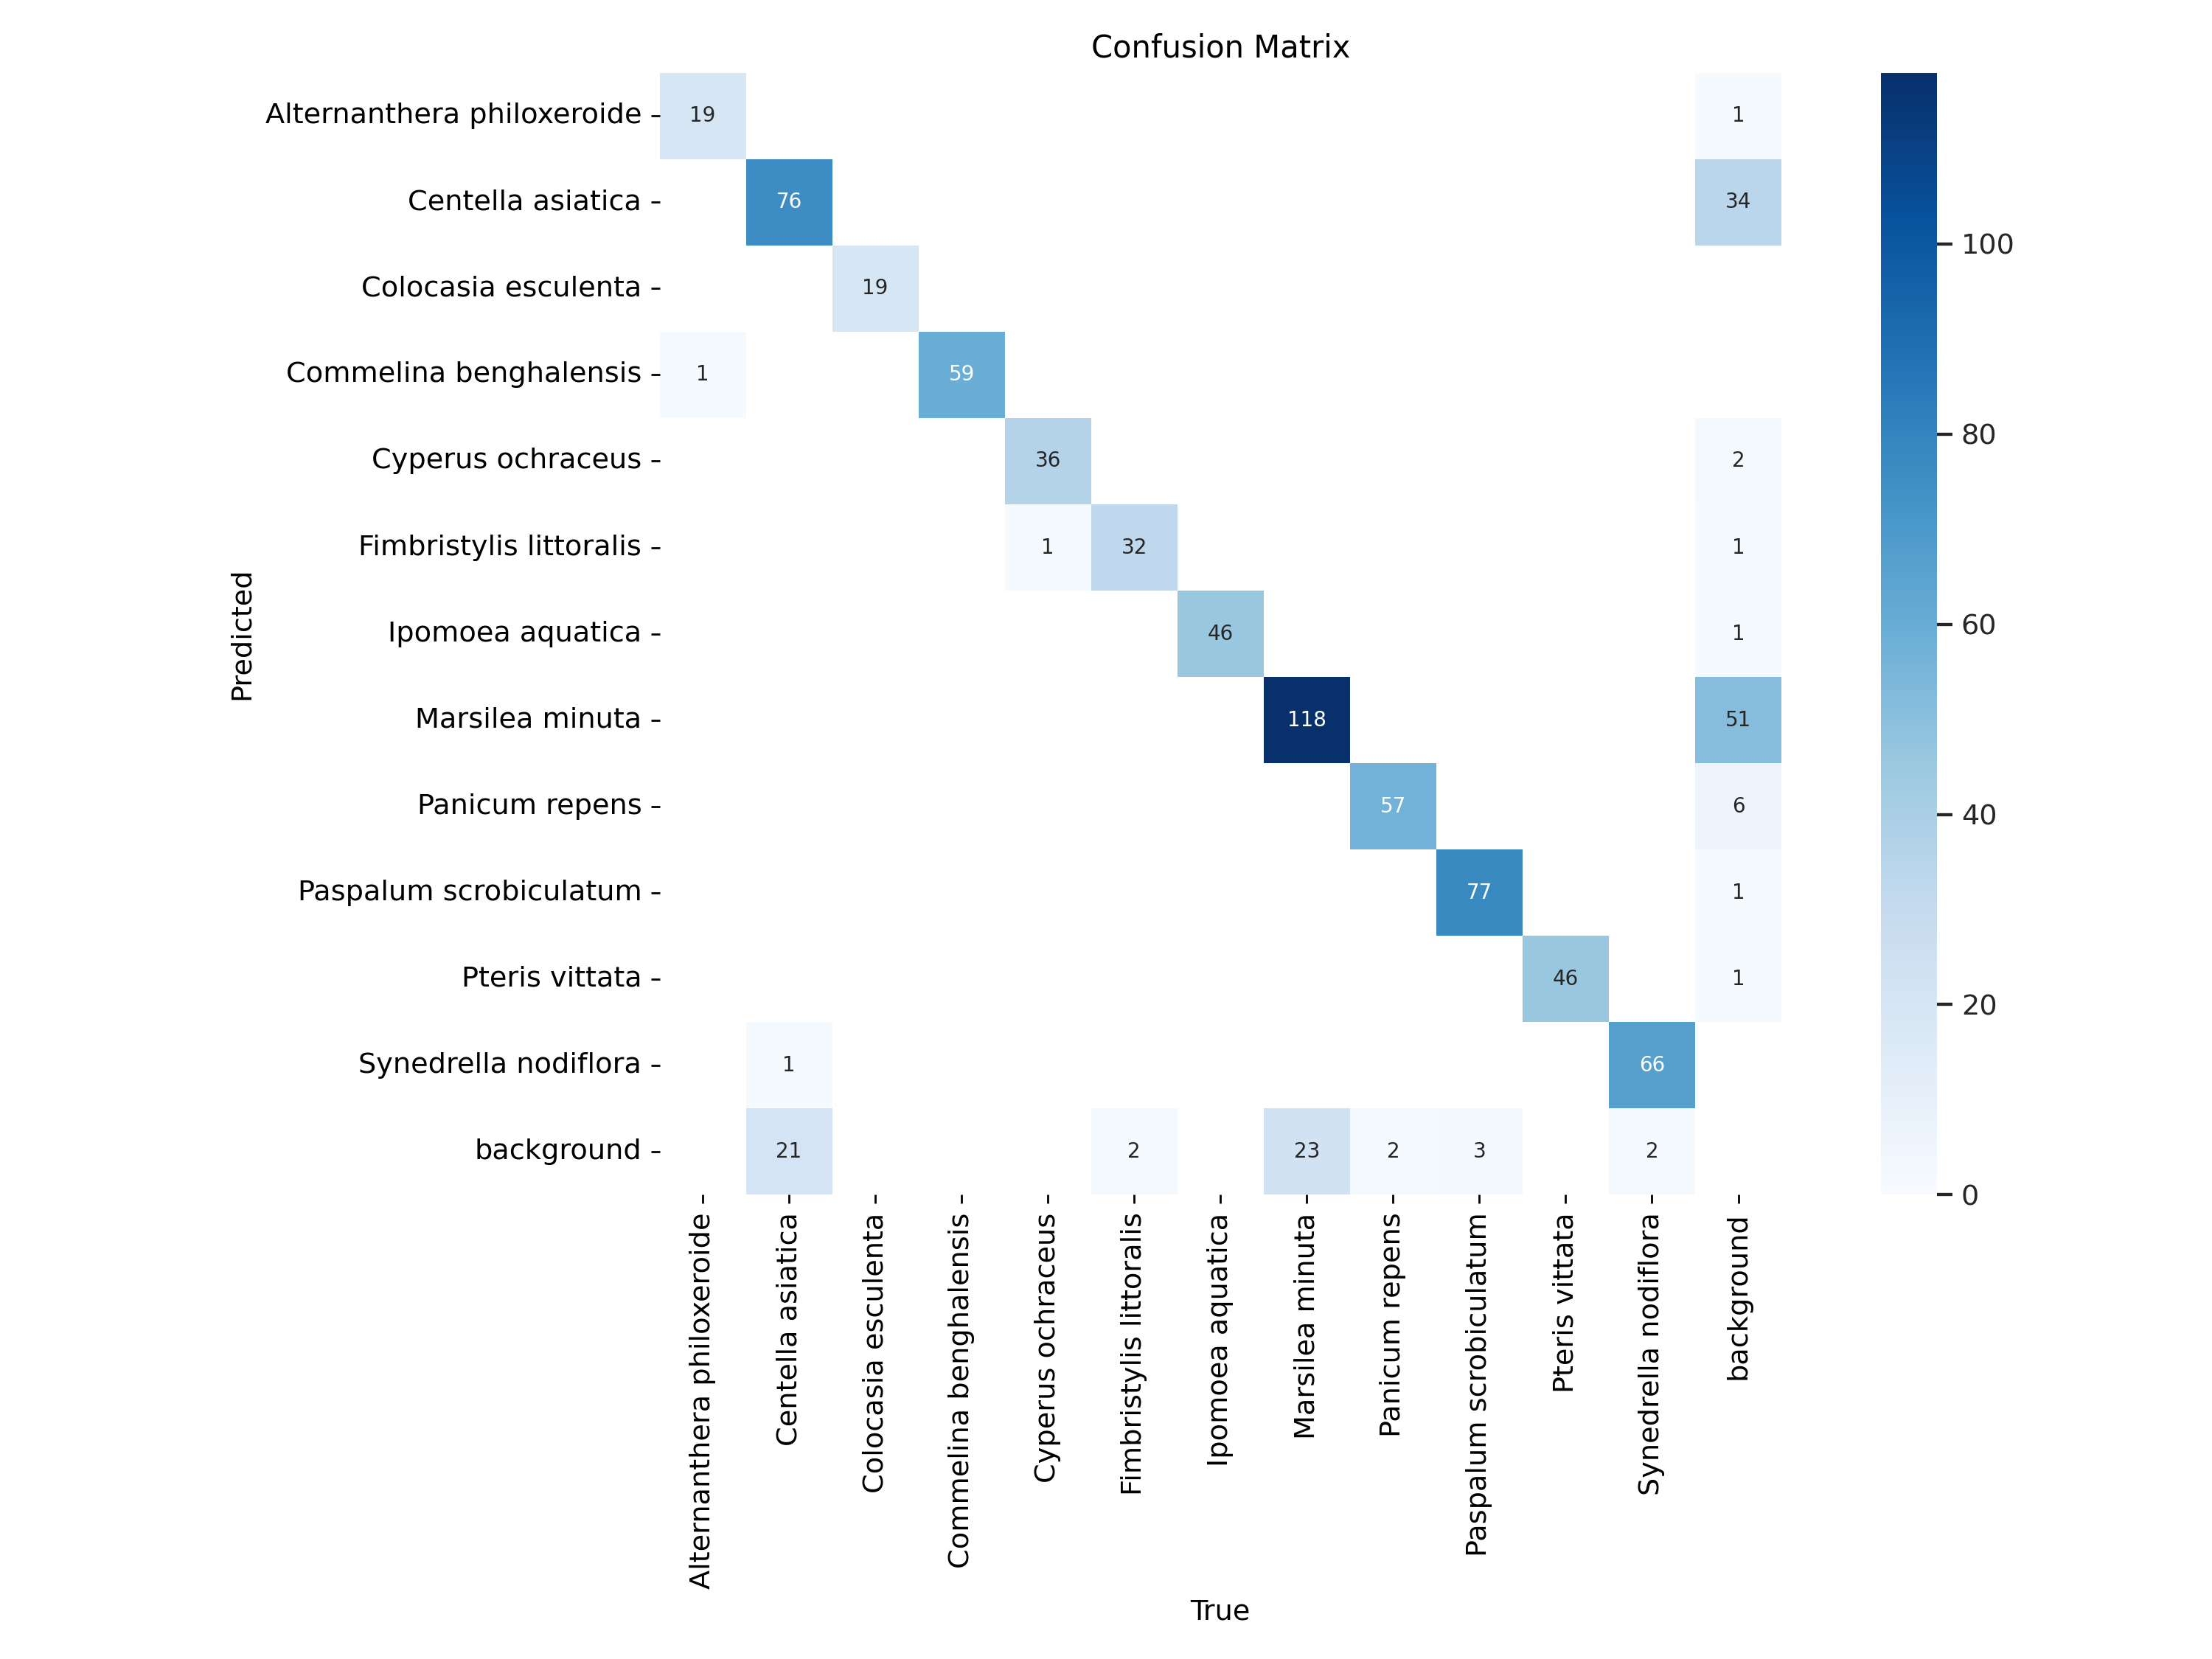

In [14]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

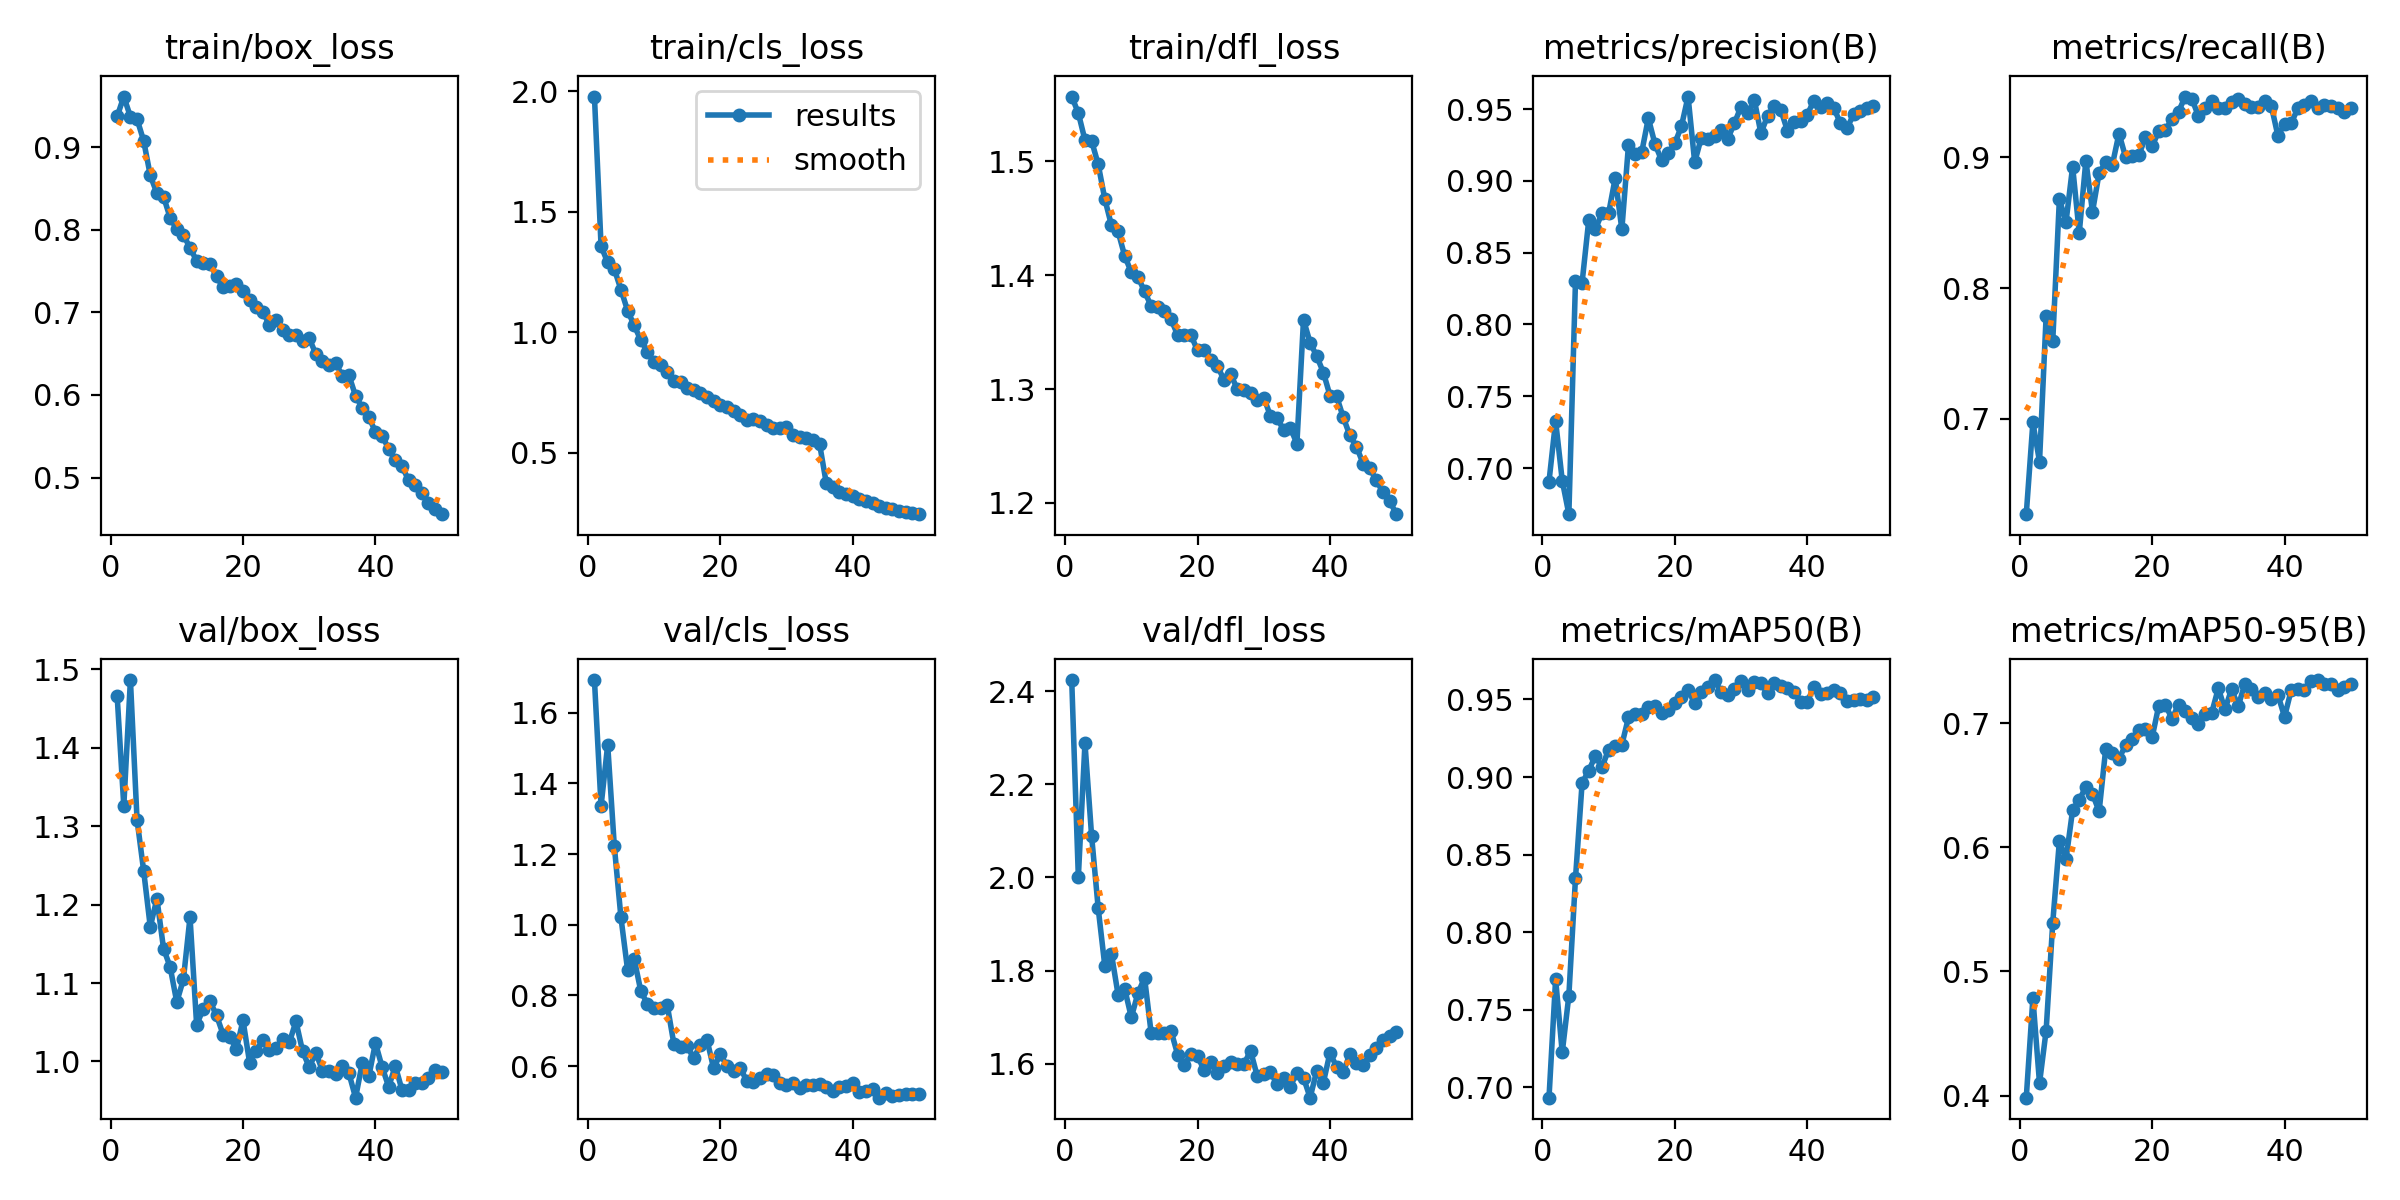

In [15]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [16]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['Alternanthera philoxeroide',
 'Centella asiatica',
 'Colocasia esculenta',
 'Commelina benghalensis',
 'Cyperus ochraceus',
 'Fimbristylis littoralis',
 'Ipomoea aquatica',
 'Marsilea minuta',
 'Panicum repens',
 'Paspalum scrobiculatum',
 'Pteris vittata',
 'Synedrella nodiflora']

In [17]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [18]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.6616340364710276
mAP 50 0.9205790142647593
mAP 75 0.6996082506017663


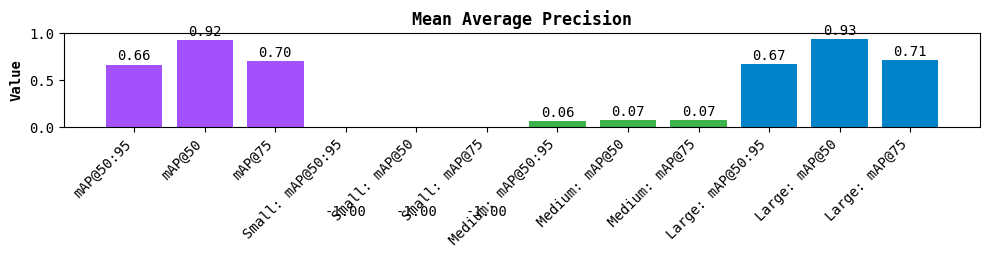

In [19]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [20]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

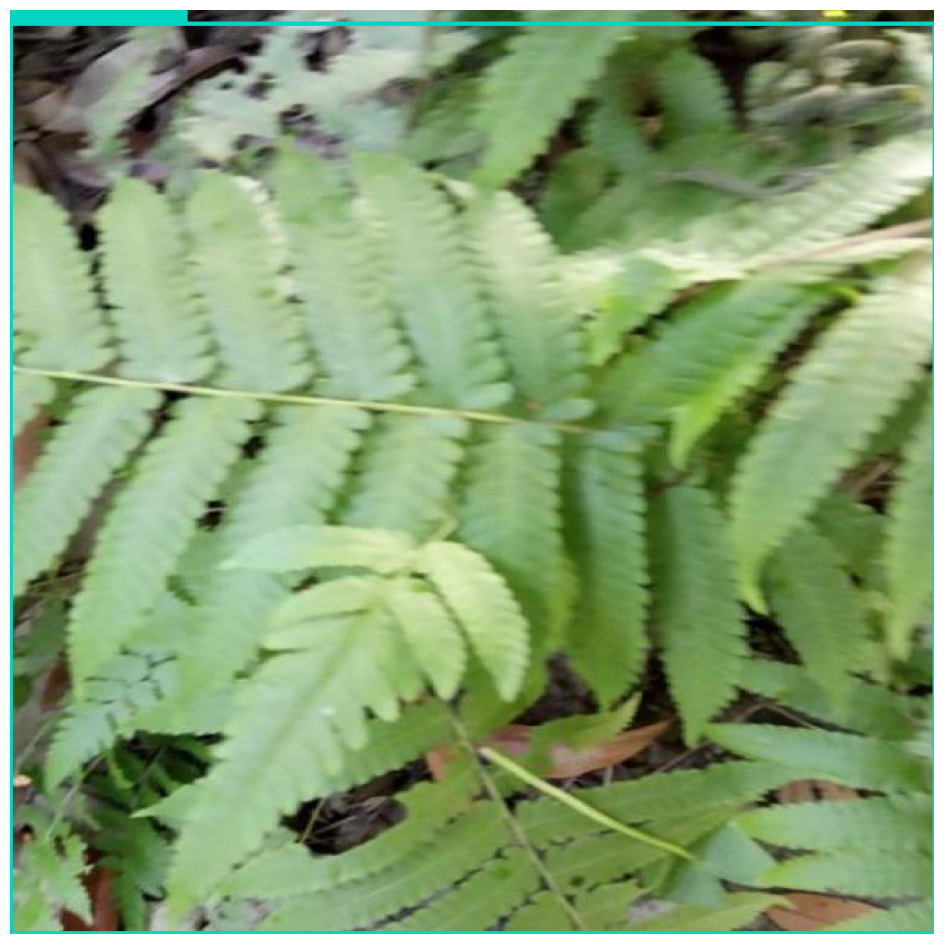

In [21]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)